In [1]:
import pandas as pd
import numpy as np
import re, string
import nltk.corpus

from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD

In [2]:
train = pd.read_csv('../quora-insincere-questions-classification/train.csv')
train.head(3)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0


In [3]:
test = pd.read_csv('../quora-insincere-questions-classification/test.csv')
test.head(3)

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...


In [4]:
train.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

In [5]:
# cleaning the data
nltk.download('stopwords')
nltk.download('wordnet') 
nltk.download('omw-1.4')
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    text = nopunct.split(' ')
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(text)) # remove unicode characters
    text = re.sub(r'[^a-zA-Z\s]+', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in stop]) # remove stop words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')]) # lemmatization
    text = re.sub(' +', ' ', text) # remove extra spaces
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joensbj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joensbj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\joensbj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
# tqdm.pandas()
# train_clean = train
# train_clean['clean_text'] = train['question_text'].progress_apply(clean_text)

In [7]:
# if you have already saved the cleaned strings you can start from here
train_clean = pd.read_csv('../quora-insincere-questions-classification/train_clean.csv')
train_clean.head()

,Unnamed: 0,qid,question_text,target,clean_text
0,0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,quebec nationalist see province nation
1,1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,adopted dog would encourage people adopt shop
2,2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,velocity affect time velocity affect space geo...
3,3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,otto von guericke used magdeburg hemisphere
4,4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,convert montra helicon mountain bike changing ...


In [8]:
train['question_text'].iloc[0]

'How did Quebec nationalists see their province as a nation in the 1960s?'

In [9]:
train_clean['clean_text'].iloc[0]

'quebec nationalist see province nation '

In [10]:
# train_clean.to_csv('../quora-insincere-questions-classification/train_clean.csv')

In [11]:
train_clean = train_clean[['clean_text','target']]
train_clean.head(3)

,clean_text,target
0,quebec nationalist see province nation,0
1,adopted dog would encourage people adopt shop,0
2,velocity affect time velocity affect space geo...,0


In [12]:
(X_train,X_test,y_train,y_test) = train_test_split(train_clean['clean_text'],train_clean['target'],train_size=0.8,stratify=train_clean['target'])
X_train.head(3)

908858         macbook pro good choice computer programmer 
795270    trump realize healthcare complicated recently ...
700831                 plant animal american europe traded 
Name: clean_text, dtype: object

In [13]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
X_train = vectorizer.fit_transform(X_train.astype('U'))
X_test = vectorizer.transform(X_test.astype('U'))
X_train

<1044897x149250 sparse matrix of type '<class 'numpy.float64'>'
	with 5813418 stored elements in Compressed Sparse Row format>

In [14]:
X_train.shape

(1044897, 149250)

In [15]:
# train on a smaller set of the training data to reduce time as 1044897 is a lot of entries
sample_size = round(X_train.shape[0]/100)
X_sample = X_train[0:sample_size]
y_sample = y_train[0:sample_size]

C:\Users\joensbj\AppData\Local\Temp\ipykernel_40084\4184090464.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_sample = y_train[0:sample_size]


In [16]:
knn = KNeighborsClassifier()
knnCV = cross_validate(knn,X_sample,y_sample)

In [17]:
knnCV['test_score'].mean()

0.9382716484845431

In [18]:
grid = {'n_neighbors':np.arange(1,50)}
gridCV = GridSearchCV(KNeighborsClassifier(),param_grid=grid,n_jobs=-1)
gridCV.fit(X_sample,y_sample)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [19]:
print(gridCV.best_score_)
print(gridCV.best_params_)

0.9383673422644474
{'n_neighbors': 4}


<AxesSubplot: xlabel='n neighbors'>

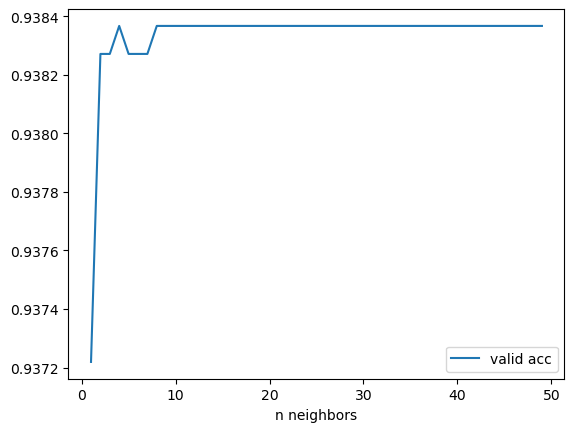

In [20]:
gridCV_results = pd.DataFrame()
gridCV_results['n neighbors'] = grid['n_neighbors']
gridCV_results['valid acc'] = gridCV.cv_results_['mean_test_score']
gridCV_results.plot(x='n neighbors',y='valid acc')

In [21]:
bestKNN = gridCV.best_estimator_
bestKNN.fit(X_sample,y_sample)

KNeighborsClassifier(n_neighbors=4)

In [22]:
# bestKNN.score(X_test,y_test)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    245063
           1       0.51      0.00      0.00     16162

    accuracy                           0.94    261225
   macro avg       0.72      0.50      0.49    261225
weighted avg       0.91      0.94      0.91    261225



(array([0.5, 1.5]), [Text(0, 0.5, 'sincere'), Text(0, 1.5, 'insincere')])

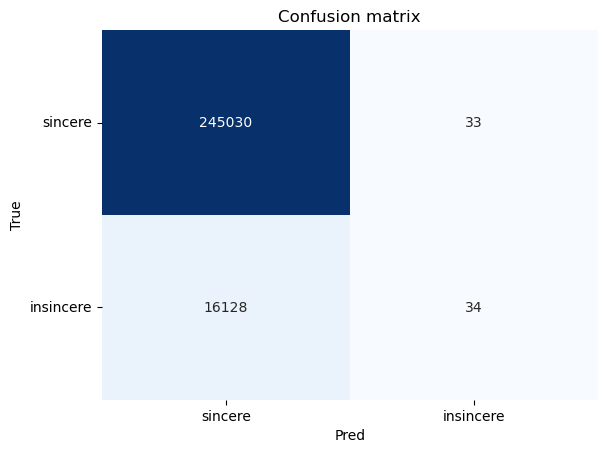

In [23]:
knn = KNeighborsClassifier()
knn.fit(X_sample, y_sample)
pred = knn.predict(X_test)
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=['sincere','insincere'], 
       yticklabels=['sincere','insincere'], title="Confusion matrix")
plt.yticks(rotation=0)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    245063
           1       0.64      0.00      0.00     16162

    accuracy                           0.94    261225
   macro avg       0.79      0.50      0.49    261225
weighted avg       0.92      0.94      0.91    261225



(array([0.5, 1.5]), [Text(0, 0.5, 'sincere'), Text(0, 1.5, 'insincere')])

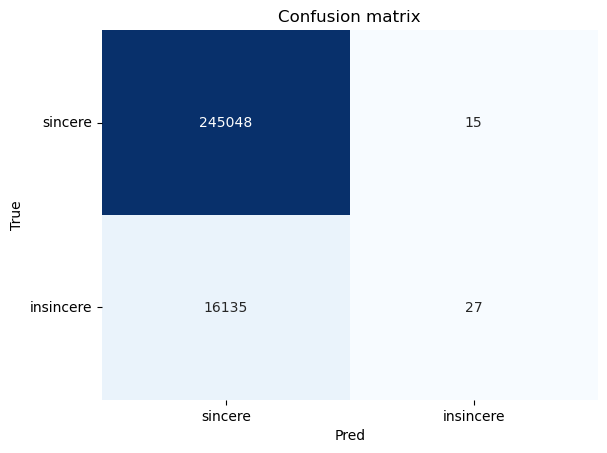

In [24]:
pred = bestKNN.predict(X_test)
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=['sincere','insincere'], 
       yticklabels=['sincere','insincere'], title="Confusion matrix")
plt.yticks(rotation=0)

In [25]:
X_train.shape

(1044897, 149250)

In [41]:
tsvd = TruncatedSVD(n_components=40)
tsvd.fit(X_train)

TruncatedSVD(n_components=40)

In [43]:
cols = ['PC-'+str(i+1) for i in range(40)]
cols
PVE = tsvd.explained_variance_ratio_
PVE = pd.Series(PVE,index=cols)
print(PVE.head())
PVE.sum()

PC-1    0.002292
PC-2    0.002969
PC-3    0.002395
PC-4    0.002228
PC-5    0.002046
dtype: float64


0.060489177475730314

<AxesSubplot: title={'center': 'PVE'}>

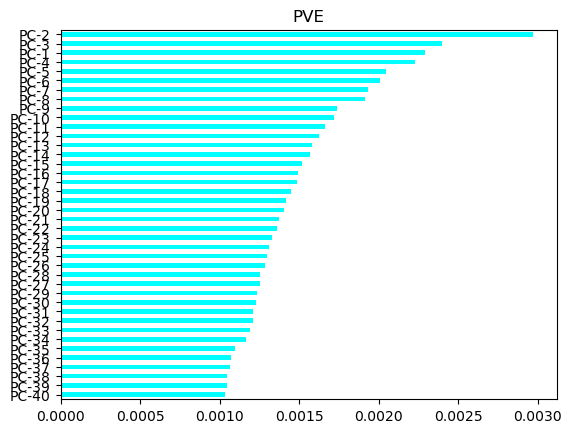

In [44]:
PVE.sort_values().plot.barh(color='cyan',title='PVE')

In [45]:
Z_train = tsvd.transform(X_train)
Z_train = pd.DataFrame(Z_train,columns=cols)
Z_sample = tsvd.transform(X_sample)
Z_sample = pd.DataFrame(Z_sample,columns=cols)
Z_train.head(3)

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-31,PC-32,PC-33,PC-34,PC-35,PC-36,PC-37,PC-38,PC-39,PC-40
0,0.062131,-0.025043,-0.074709,-0.171237,-0.030798,0.171416,-0.004183,0.016161,-0.020631,0.009906,...,-0.026144,-0.005095,-0.046114,0.001856,0.008982,-0.022034,-0.044494,-0.063297,0.005794,-0.007773
1,0.030195,-0.021697,-0.004239,-0.003668,0.024043,-0.009865,0.006391,0.003919,0.012277,-0.019354,...,-0.007447,-0.039174,-0.012917,-0.015595,0.065393,0.005858,-0.065506,-0.026885,-0.006651,-0.032627
2,0.022774,-0.018268,-0.001842,0.000820,0.006965,-0.003369,-0.000365,0.000046,0.006630,-0.013961,...,0.003261,0.008889,0.023016,0.006646,0.073520,0.005133,-0.030512,0.021448,-0.006434,-0.034857


In [46]:
X_train.shape

(1044897, 149250)

In [47]:
gridCV_pca = GridSearchCV(KNeighborsClassifier(),param_grid=grid,n_jobs=-1)
gridCV_pca.fit(Z_sample,y_sample)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [48]:
print(gridCV_pca.best_score_)
print(gridCV_pca.best_params_)

0.9384631276611826
{'n_neighbors': 30}


<AxesSubplot: xlabel='n neighbors'>

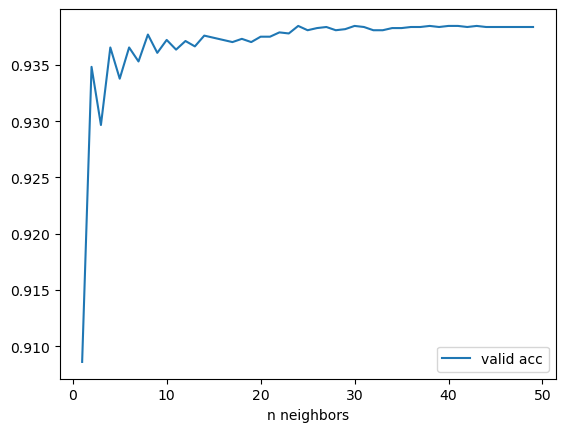

In [51]:
gridCV_pca_results = pd.DataFrame()
gridCV_pca_results['n neighbors'] = grid['n_neighbors']
gridCV_pca_results['valid acc'] = gridCV_pca.cv_results_['mean_test_score']
gridCV_pca_results.plot(x='n neighbors',y='valid acc')

In [52]:
bestKNN_pca = gridCV_pca.best_estimator_
bestKNN_pca.fit(X_sample,y_sample)

KNeighborsClassifier(n_neighbors=30)

1183521    0
382430     0
767977     0
Name: target, dtype: int64
0
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    245063
           1       0.00      0.00      0.00     16162

    accuracy                           0.94    261225
   macro avg       0.47      0.50      0.48    261225
weighted avg       0.88      0.94      0.91    261225



(array([0.5, 1.5]), [Text(0, 0.5, 'sincere'), Text(0, 1.5, 'insincere')])

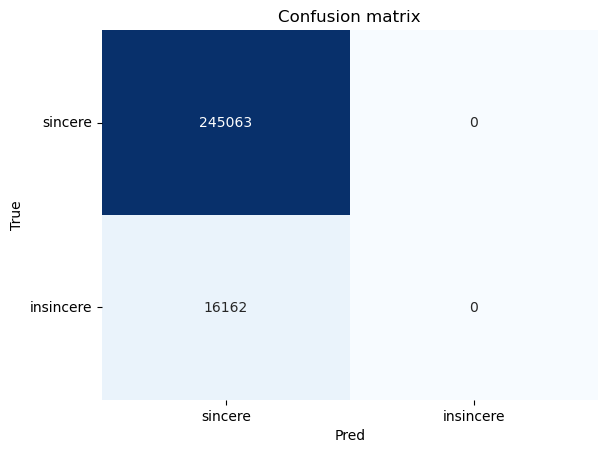

In [60]:
pred = bestKNN_pca.predict(X_test)
print(classification_report(y_test, pred,zero_division=0))
cm = confusion_matrix(y_test, pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=['sincere','insincere'], 
       yticklabels=['sincere','insincere'], title="Confusion matrix")
plt.yticks(rotation=0)